# Experiment on finance data

Dataset used is the currency enchange with respect to USD dollars, from daily measurements from the last 2 years (2017-2018).

Currencies used: 
- Reference: USA
- Canadian dollar (CAD)
- Euro (EUR)
- Japanese yen (JPY)
- Great british pound (GBP)
- Swiss franc (CHF)
- Austrial dollar (AUD)
- Hong Kong dollar (HKD)
- New zealand dollar (NZD)
- South korean won (KRW)
- Mexican peso (MXN)

---

Inflation data 
https://data.oecd.org/price/inflation-cpi.htm


Priors for magnitude:

currency_prior = np.array([1, 1, 3.5, 1, 1, 1, 1, 1, 50., 1])

gonu_prior = np.array([1352., 84.   ,8038.,  128.])

In [16]:
import mogptk

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [17]:
# plot config
sns.set_context('paper', font_scale=1.4)
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (10, 5)

## Load dataset

In [5]:
col_names = ['EUR/USD', 'CAD/USD', 'JPY/USD', 'GBP/USD', 'CHF/USD',
             'AUD/USD', 'HKD/USD','NZD/USD', 'KRW/USD','MXN/USD']

data_list = []
for names in col_names:
    data_list.append(mogptk.LoadCSV(
        'data/currency_exchange/final_dataset.csv',
        x_col='Date',
        y_col=names,
        formats={'Date': mogptk.FormatDate}))
dataset = mogptk.DataSet(data_list)

for i, channel in enumerate(dataset):
    channel.filter('2017-01-03', '2018-01-01')

In [6]:
# Preprocess by randomly removing points and detrending
cols2keep = [0, 2, 5]
for i, channel in enumerate(dataset):
    channel.transform(mogptk.TransformDetrend)
    channel.remove_randomly(pct=0.3)
    
    if i not in cols2keep:
        channel.remove_range('2017-11-17', None)
    
# simulate sensor failure
dataset[1].remove_range('2017-03-31', '2017-05-01')
dataset[2].remove_range('2017-12-28', None)
dataset[3].remove_range('2017-07-20', '2017-09-08')
dataset[4].remove_range(None, '2017-01-31')
dataset[5].remove_range('2017-12-28', None)
dataset[7].remove_range(None, '2017-01-31')

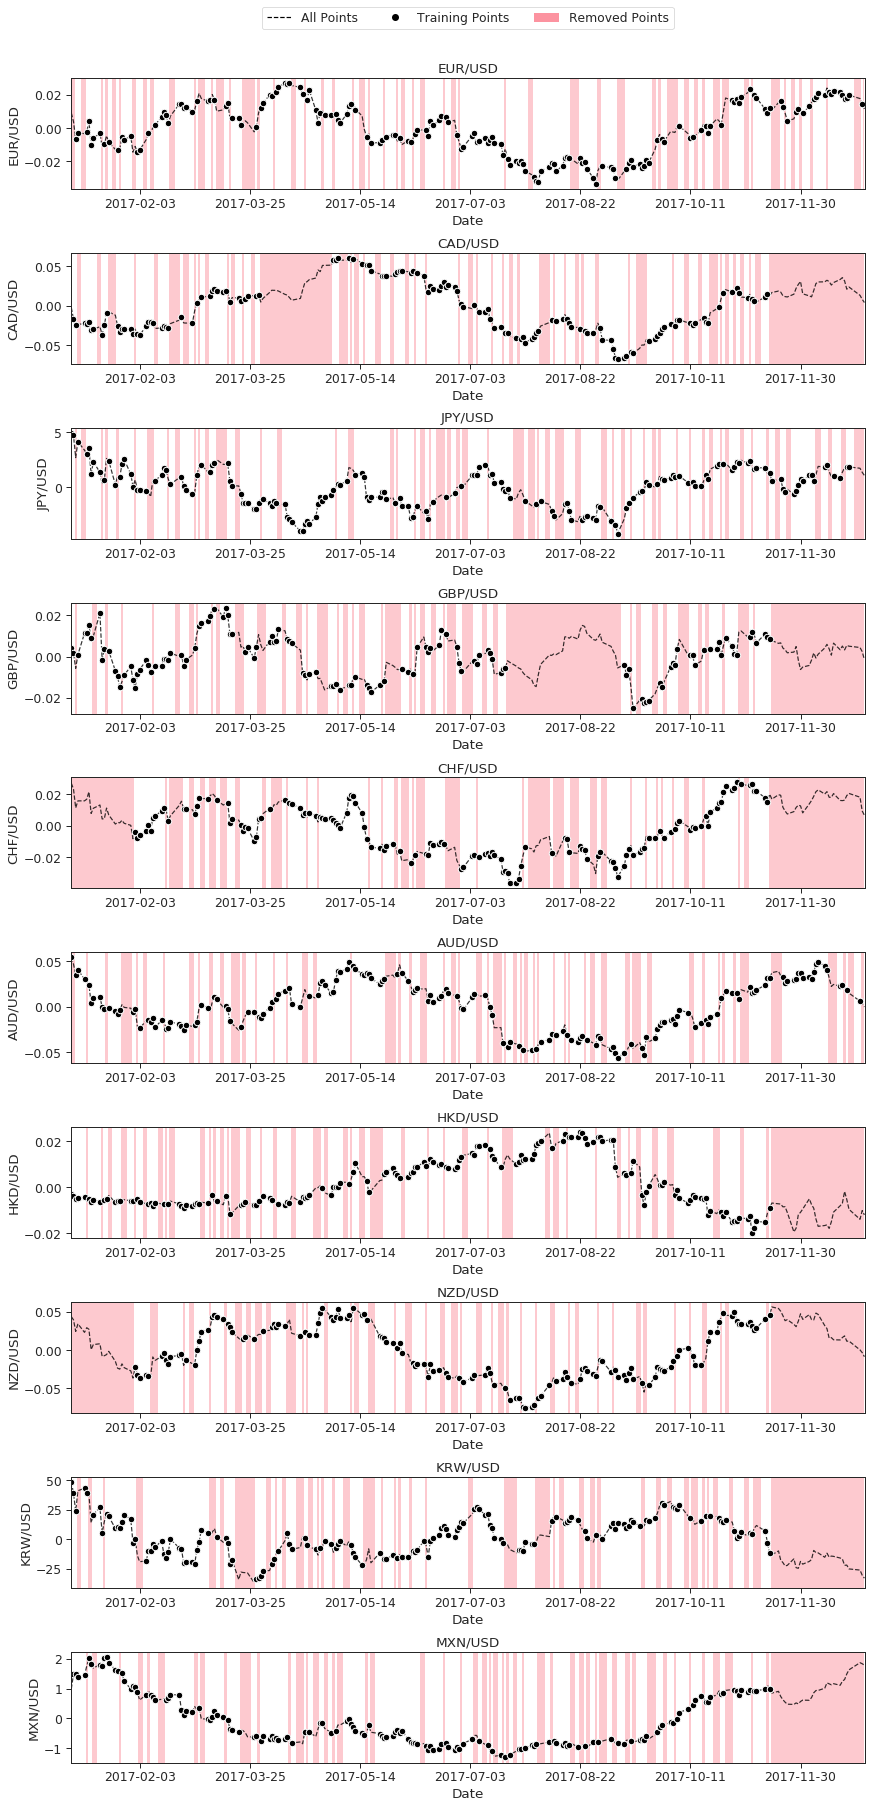

In [7]:
dataset.plot();

## Create and fit model

In [ ]:
x_test, y_test = model_mosm.dataset.get_test_data()

## MOSM

In [ ]:
n_trials = 1

mosm_list = []
mosm_mae = np.zeros((n_trials, len(dataset)))
mosm_nmae = np.zeros((n_trials, len(dataset)))
mosm_rmse = np.zeros((n_trials, len(dataset)))
mosm_nrmse = np.zeros((n_trials, len(dataset)))

for n in range(n_trials):
    model_mosm = mogptk.MOSM(dataset, Q=5)
    model_mosm.init_parameters('BNSE')
    
    print('Starting trial', n)
    model_mosm.train(method='L-BFGS-B', maxiter=1000, tol=1e-10, verbose=True)
    print('Finished trial', n)
    print('='*50)        
    mosm_list.append(model_mosm)
    
    # errors per channel
    error = mogptk.test_errors(model_mosm, x_test=x_test, y_test=y_test)

    mosm_mae[n, :] = np.array(error[0])[:, 0]
    mosm_nmae[n, :] = np.array(error[0])[:, 1]
    mosm_rmse[n, :] = np.array(error[0])[:, 2]
    mosm_nrmse[n, :] = np.array(error[0])[:, 3]

In [18]:
pd.DataFrame(np.c_[
    mosm_mae.mean(0), mosm_nmae.mean(0), mosm_rmse.mean(0),
    mosm_mae.std(0), mosm_nmae.std(0), mosm_rmse.std(0)],
    columns=['MAE', 'nmae', 'RMSE', 'MAE std', 'nmae% std', 'RMSE std'])

,MAE,nmae,RMSE,MAE std,nmae% std,RMSE std
0,0.002868,0.022193,0.003782,0.0,0.0,0.0
1,0.005282,0.034594,0.006835,0.0,0.0,0.0
2,0.404129,0.056051,0.518618,0.0,0.0,0.0
3,0.003173,0.038083,0.004047,0.0,0.0,0.0
4,0.004648,0.060112,0.006215,0.0,0.0,0.0
5,0.004523,0.034870,0.005605,0.0,0.0,0.0
6,0.002808,0.040232,0.003869,0.0,0.0,0.0
7,0.014370,0.113421,0.019574,0.0,0.0,0.0
8,8.070979,0.060821,11.626525,0.0,0.0,0.0
9,0.193924,0.047057,0.338615,0.0,0.0,0.0


In [20]:
mosm_mae = np.zeros((n_trials, len(dataset)))
mosm_nmae = np.zeros((n_trials, len(dataset)))
mosm_rmse = np.zeros((n_trials, len(dataset)))
mosm_nrmse = np.zeros((n_trials, len(dataset)))

for model in mosm_list:
    error = mogptk.test_errors(model, x_test=x_test, y_test=y_test)
    
    mosm_mae[n, :] = np.array(error[0])[:, 0]
    mosm_nmae[n, :] = np.array(error[0])[:, 1]
    mosm_rmse[n, :] = np.array(error[0])[:, 2]
    mosm_nrmse[n, :] = np.array(error[0])[:, 3]

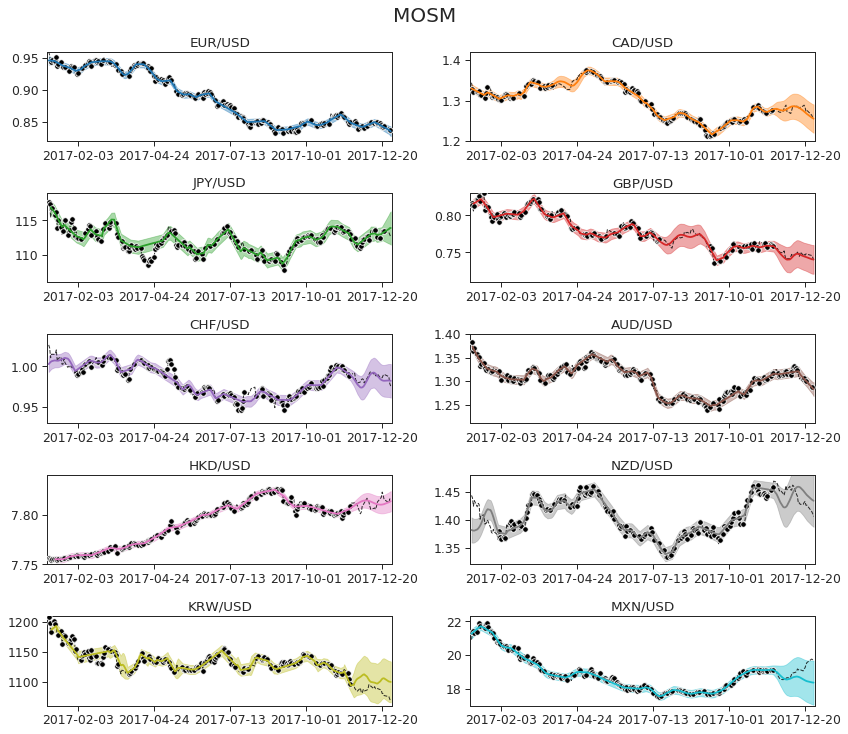

In [25]:
best_model = mosm_list[np.argmin(mosm_nmae.mean(1))]

ylims = [(0.82, .96), (1.20, 1.42),
         (106, 119), (0.71, 0.83),
         (0.93, 1.04), (1.21, 1.4),
         (7.75, 7.84), (1.32, 1.48),
         (1060, 1210), (17, 22.3)]

yticks = [(0.83, .95), (1.22, 1.4),
          (107, 117), (0.72, 0.8),
          (0.95, 1.03), (1.25, 1.39),
          (7.77, 7.83), (1.34, 1.46),
          (1080, 1190), (18, 21)]


ylims2 = [(0.82, .89), (1.20, 1.32),
         (106, 116), (0.72, 0.79),
         (0.93, 1.01), (1.21, 1.35),
         (7.795, 7.835), (1.32, 1.49),
         (1060, 1170), (17, 20)]

yticks2 = [(0.83, .87), (1.21, 1.31),
           (107, 115), (0.73, 0.78),
           (0.95, 0.99), (1.23, 1.33),
           (7.80, 7.83), (1.35, 1.45),
           (1080, 1150), (17.5, 19.5)]


f, axarr = best_model.plot_prediction(
                       grid=(5, 2),
                       title='MOSM',
                       ylims=ylims);
# plt.savefig('output/mosm_exchange_rate_zoomed.pdf', bbox_inches='tight')
# plt.savefig('output/mosm_exchange_rate.pdf', bbox_inches='tight')

## CSM

In [28]:
n_trials = 1

csm_mae = np.zeros((n_trials, len(dataset)))
csm_nmae = np.zeros((n_trials, len(dataset)))
csm_rmse = np.zeros((n_trials, len(dataset)))
csm_nrmse = np.zeros((n_trials, len(dataset)))
csm_list = []

for n in range(n_trials):
    model_csm = mogptk.CSM(dataset, Q=5)
    model_csm.init_parameters('BNSE')
    
    print('Starting trial', n)
    model_csm.train(method='L-BFGS-B', maxiter=1000, tol=1e-10)
    print('Finished trial', n)
    print('='*50)
    csm_list.append(model_csm)
    
    # errors per channel
    error = mogptk.test_errors(model_csm, x_test=x_test, y_test=y_test)
    
    csm_mae[n, :] = np.array(error[0])[:, 0]
    csm_nmae[n, :] = np.array(error[0])[:, 1]
    csm_rmse[n, :] = np.array(error[0])[:, 2]
    csm_nrmse[n, :] = np.array(error[0])[:, 3]

Starting trial 0
Finished trial 0
CPU times: user 24min 13s, sys: 1min 8s, total: 25min 22s
Wall time: 22min 11s


In [29]:
pd.DataFrame(np.c_[
    csm_mae.mean(0), csm_nmae.mean(0), csm_rmse.mean(0),
    csm_mae.std(0), csm_nmae.std(0), csm_rmse.std(0)],
    columns=['MAE', 'nmae', 'RMSE', 'MAE std', 'nmae% std', 'RMSE std'])

,MAE,nmae,RMSE,MAE std,nmae% std,RMSE std
0,0.003030,0.023444,0.003962,0.0,0.0,0.0
1,0.011288,0.073920,0.015094,0.0,0.0,0.0
2,0.512504,0.071082,0.682500,0.0,0.0,0.0
3,0.006725,0.080714,0.008525,0.0,0.0,0.0
4,0.004960,0.064144,0.006581,0.0,0.0,0.0
5,0.005270,0.040629,0.006399,0.0,0.0,0.0
6,0.002784,0.039887,0.003864,0.0,0.0,0.0
7,0.013520,0.106710,0.016096,0.0,0.0,0.0
8,9.468556,0.071353,11.285278,0.0,0.0,0.0
9,0.305455,0.074121,0.575148,0.0,0.0,0.0


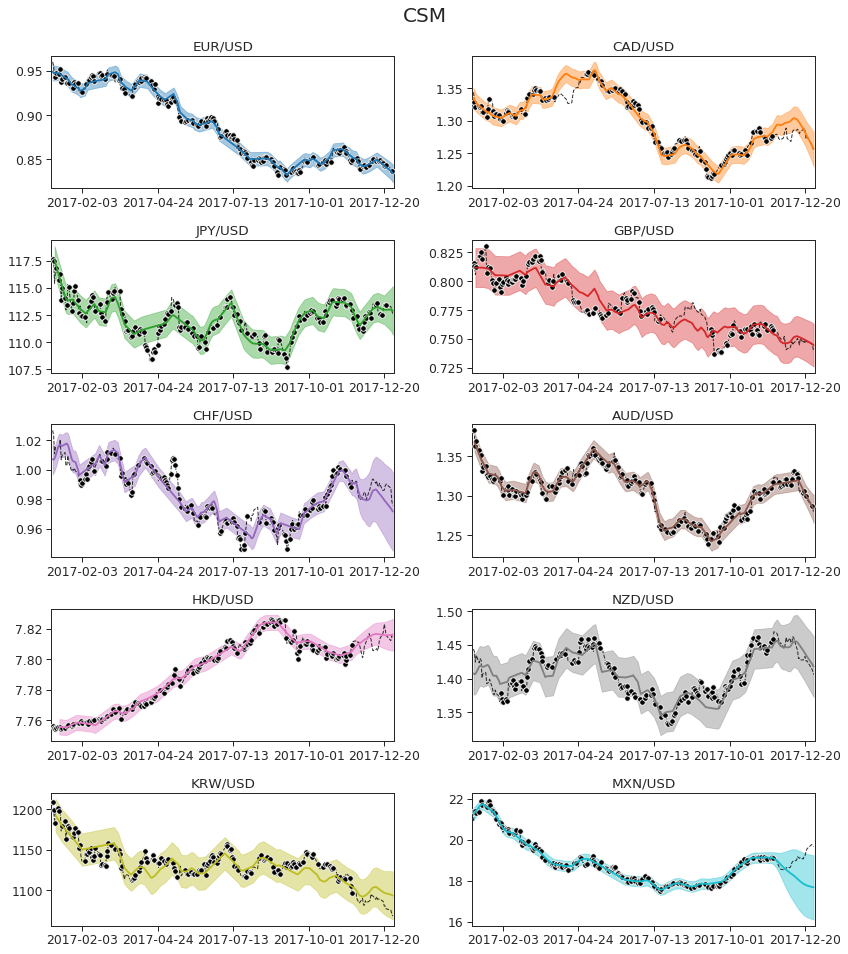

In [31]:
best_csm = csm_list[np.argmin(csm_nmae.mean(1))]
model_csm.plot_prediction(grid=(5, 2), title='CSM');

In [32]:
csm_errors = []
for model in csm_list:
    csm_errors.append(mogptk.test_errors(model, x_test=x_test, y_test=y_test, raw_errors=True))

## SM-LMC

In [34]:
n_trials = 1

smlmc_mae = np.zeros((n_trials, len(dataset)))
smlmc_nmae = np.zeros((n_trials, len(dataset)))
smlmc_rmse = np.zeros((n_trials, len(dataset)))
smlmc_nrmse = np.zeros((n_trials, len(dataset)))

smlmc_list = []

for n in range(n_trials):
    print('Trial ', n)
    model_smlmc = mogptk.SM_LMC(dataset, Q=5)
    model_smlmc.init_parameters('BNSE')
    
    model_smlmc.train(method='L-BFGS-B', maxiter=1000, tol=1e-10)
    
    smlmc_list.append(model_smlmc)
    
    error = mogptk.test_errors(model_smlmc, x_test=x_test, y_test=y_test)
    
    smlmc_mae[n, :] = np.array(error[0])[:, 0]
    smlmc_nmae[n, :] = np.array(error[0])[:, 1]
    smlmc_rmse[n, :] = np.array(error[0])[:, 2]
    smlmc_nrmse[n, :] = np.array(error[0])[:, 3]

Trial  0


In [35]:
pd.DataFrame(np.c_[
    smlmc_mae.mean(0), smlmc_nmae.mean(0), smlmc_rmse.mean(0),
    smlmc_mae.std(0), smlmc_nmae.std(0), smlmc_rmse.std(0)],
    columns=['MAE', 'nmae%', 'RMSE', 'MAE std', 'nmae% std', 'RMSE std'])

,MAE,nmae%,RMSE,MAE std,nmae% std,RMSE std
0,0.003696,0.028603,0.004876,0.0,0.0,0.0
1,0.012494,0.081819,0.017473,0.0,0.0,0.0
2,0.818768,0.113560,1.046168,0.0,0.0,0.0
3,0.013726,0.164744,0.020341,0.0,0.0,0.0
4,0.006962,0.090024,0.009151,0.0,0.0,0.0
5,0.005343,0.041195,0.006463,0.0,0.0,0.0
6,0.004675,0.066976,0.006975,0.0,0.0,0.0
7,0.017621,0.139074,0.021372,0.0,0.0,0.0
8,16.633604,0.125347,29.853385,0.0,0.0,0.0
9,0.169607,0.041157,0.264622,0.0,0.0,0.0


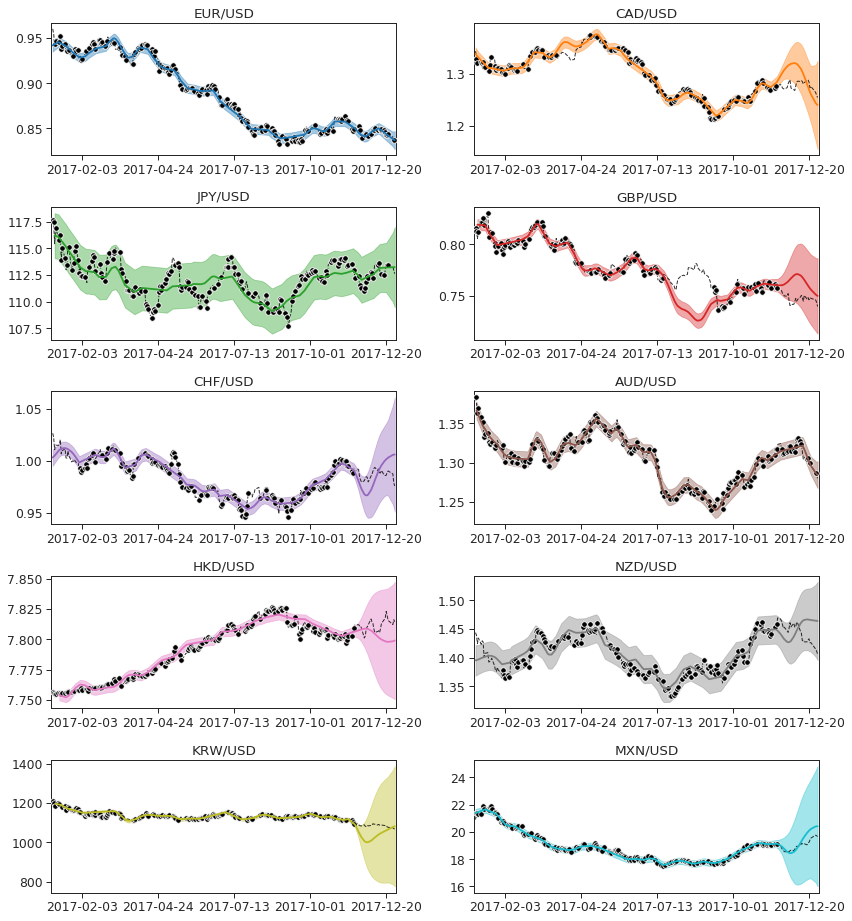

In [36]:
best_smlmc = smlmc_list[np.argmin(smlmc_nmae.mean(1))]
best_smlmc.plot_prediction(
                       grid=(5, 2),
                       title='');

In [37]:
smlmc_errors = []
for model in smlmc_list:
    smlmc_errors.append(mogptk.test_errors(model, x_test=x_test, y_test=y_test, raw_errors=True))

## IGP
Independant gaussian process with spectral mixture kernel

In [41]:
n_trials = 1

igp_mae = np.zeros((n_trials, len(dataset)))
igp_nmae = np.zeros((n_trials, len(dataset)))
igp_rmse = np.zeros((n_trials, len(dataset)))
igp_nrmse = np.zeros((n_trials, len(dataset)))

for n in range(n_trials):
    print('Trial ', n)
    
    igp_list = []
    
    for i in range(len(dataset)):
        
        # data[i].X = data[i].X.astype(float)
        
        model_sm = mogptk.SM(dataset[i], Q=3)
        model_sm.init_parameters('BNSE')
        model_sm.train(method='L-BFGS-B', maxiter=1000, tol=1e-10)
        
        igp_list.append(model_sm)
        
        error = mogptk.test_errors(model_sm, x_test=[x_test[i]], y_test=[y_test[i]])
    
        igp_mae[n, i] = np.array(error[0])[:, 0]
        igp_nmae[n, i] = np.array(error[0])[:, 1]
        igp_rmse[n, i] = np.array(error[0])[:, 2]
        igp_nrmse[n, i] = np.array(error[0])[:, 3]
    print('='*50)

Trial  0


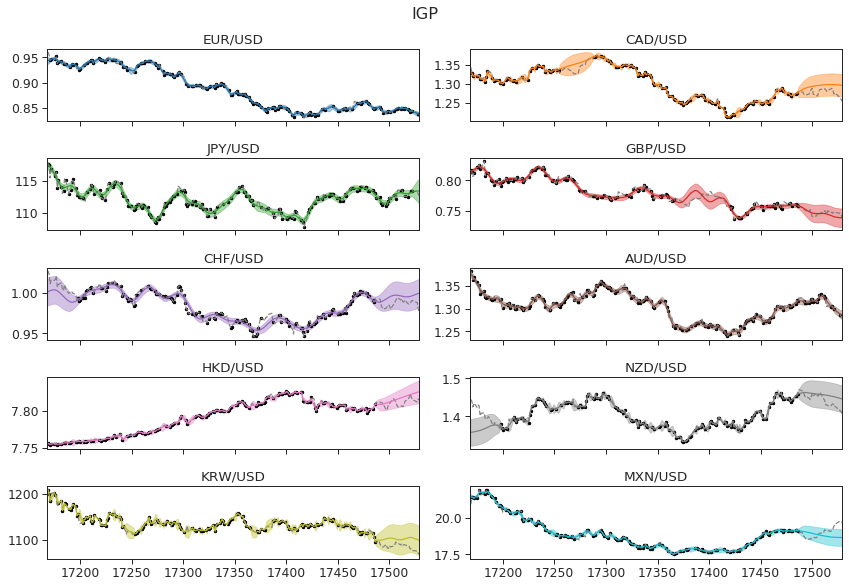

In [42]:
f, axarr = plt.subplots(5, 2, sharex=True, figsize=(12, 8))
axarr = axarr.reshape(-1)

for i in range(len(dataset)):
    c = igp_list[i].dataset[0]
    x_train = c.X[c.mask,:]
    y_train = c._detransform(c.Y[c.mask], c.X[c.mask,:])
    x_all = c.X
    y_all = c._detransform(c.Y, c.X)
    # prediction on test set
    x_pred = c.X
    mean_pred, lower_ci, upper_ci = igp_list[i].predict([x_pred])
    
    axarr[i].plot(x_train[:, 0], y_train, '.k', label='Train', )
    axarr[i].plot(x_all[:, 0], y_all, '--', label='Test', c='gray')

    axarr[i].plot(x_pred[:, 0], mean_pred[0], label='Post.Mean', c=sns.color_palette()[i%10])
    axarr[i].fill_between(x_pred[:, 0].reshape(-1),
                          lower_ci[0],
                          upper_ci[0],
                          label='95% c.i',
                          color=sns.color_palette()[i%10],
                          alpha=0.4)
    # axarr[i].legend(ncol=4, loc='upper center', fontsize=8)
    axarr[i].set_xlim(x_all[0]-1, x_all[-1])
    # set channels name
    axarr[i].set_title(col_names[i])
plt.suptitle('IGP', y=1.02)
plt.tight_layout()

## Compare All

In [43]:
print('mosm nMAE {:.3e} pm {:.3e} | mosm nRMSE {:.3e} pm {:.3e}'.format(
        mosm_nmae.mean(1).mean(),
        mosm_nmae.mean(1).std(),
        mosm_nrmse.mean(1).mean(),
        mosm_nrmse.mean(1).std()))

mosm nMAE 5.074e-02 pm 0.000e+00 | mosm nRMSE 6.978e-02 pm 0.000e+00


In [44]:
print('csm nMAE {:.3e} pm {:.3e} | csm nRMSE {:.3e} pm {:.3e}'.format(
        csm_nmae.mean(1).mean(),
        csm_nmae.mean(1).std(),
        csm_nrmse.mean(1).mean(),
        csm_nrmse.mean(1).std()))

csm nMAE 6.460e-02 pm 0.000e+00 | csm nRMSE 8.679e-02 pm 0.000e+00


In [45]:
print('smlmc nMAE {:.3e} pm {:.3e} | smlmc nRMSE {:.3e} pm {:.3e}'.format(
        smlmc_nmae.mean(1).mean(),
        smlmc_nmae.mean(1).std(),
        smlmc_nrmse.mean(1).mean(),
        smlmc_nrmse.mean(1).std()))

smlmc nMAE 8.925e-02 pm 0.000e+00 | smlmc nRMSE 1.267e-01 pm 0.000e+00


In [46]:

print('igp nMAE {:.3e} pm {:.3e} | igp nRMSE {:.3e} pm {:.3e}'.format(
        igp_nmae.mean(1).mean(),
        igp_nmae.mean(1).std(),
        igp_nrmse.mean(1).mean(),
        igp_nrmse.mean(1).std()))

igp nMAE 5.518e-02 pm 0.000e+00 | igp nRMSE 7.975e-02 pm 0.000e+00
